In [1]:
from itertools import islice
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from rouge_score import rouge_scorer
import seaborn as sns
import transformers

# Sweep v1 (best length)

In [2]:
tokenizer = transformers.AutoTokenizer.from_pretrained("EleutherAI/pythia-1b")
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

base = pd.concat([
    pd.read_json("data/sweep_v1_410m.jsonl", lines=True).assign(model_scale=0.410),
    pd.read_json("data/sweep_v1_1b.jsonl", lines=True).assign(model_scale=1.0),
]).reset_index()
def results():
    for length in [16, 24, 32, 48, 64, 96, 128, 192, 256, None]:
        for _, s in base.iterrows():
            n = len(tokenizer.tokenize(s["reference"])) if length is None else length
            output = tokenizer.decode(tokenizer(s.output)["input_ids"][:n])
            for name, score in scorer.score(s.reference, output).items():
                  yield dict(model_scale=s.model_scale, length=length, metric=name, **score._asdict())

df = pd.DataFrame.from_dict(results())

In [ ]:
(df.drop(columns=["precision", "recall"])
    .groupby(["model_scale", "length", "metric"]).mean()
    .reset_index()
    .groupby(["model_scale", "metric"]).apply(lambda g: g.loc[g.fmeasure.idxmax()][["length", "fmeasure"]])
    .join(df.pipe(lambda d: d[d.length.isna()]).groupby(["model_scale", "metric"]).mean()[["fmeasure"]],
          lsuffix="(length=best)", rsuffix="(length=ref)")
    .style.format({"length": "{:.0f}", "fmeasure(length=best)": "{:.3f}", "fmeasure(length=ref)": "{:.3f}"})
)

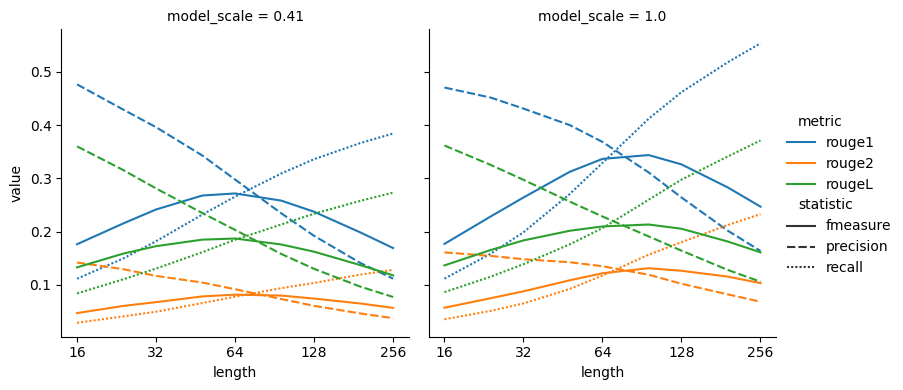

In [30]:
key = ["model_scale", "length", "metric"]
d = df.groupby(key).mean().reset_index().melt(key, var_name="statistic")
g = sns.relplot(d, col="model_scale", x="length", y="value", hue="metric", style="statistic", style_order=["fmeasure", "precision", "recall"], kind="line",
                height=4)
plt.xscale("log", base=2)
for ax in g.axes.flatten():
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

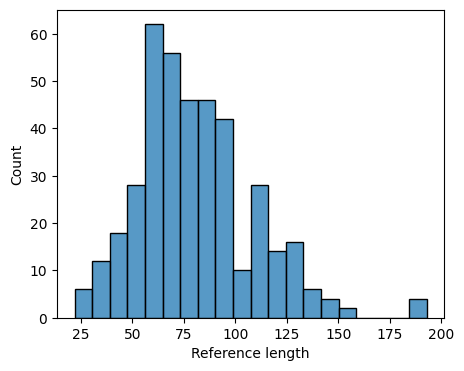

In [4]:
plt.figure(figsize=(5, 4))
sns.histplot(base.reference.map(lambda s: len(tokenizer.tokenize(s))))
plt.xlabel("Reference length");

# Sweep v0 (prompt, sparse)

 - Rouge1, Rouge2, RougeL scores are well-correlated
 - Model scale improves summaries from 410m -> 1b, but not from 1b -> 2.8b
 - Some evidence of signal: sparse_softmax_k=32 degrades performance
 - The prompt _"\nSummary:"_ performs better than _"\nOne-sentence summary:"_
 - (Anecdotally) it was hard to make 1-shot work, 0-shot seemed more sensible (less confusing to the model)

In [2]:
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
df = (pd.read_json("data/sweep_v0.jsonl", lines=True)
    .pipe(lambda d: d.join(d.apply(lambda d: pd.Series({k: score.fmeasure for k, score in scorer.score(d.reference, d.output).items()}), axis=1))))

In [43]:
(df
 .pipe(lambda d: d[d.model_scale != "6.9b"])
 .pipe(lambda d: d.assign(model_scale=d.model_scale.map({"410m": 0.41, "1b": 1.0, "2.8b": 2.8, "6.9b": 6.9}.__getitem__)))
 .drop(columns=["id", "reference", "output"])
 .groupby(["prompt", "model_scale", "sparse_softmax_k"]).mean()
 .style.format("{:.3f}")
 )

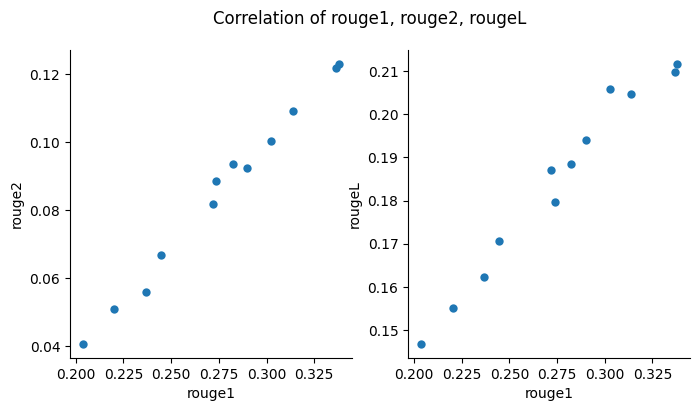

In [7]:
d = (df.pipe(lambda d: d[d.model_scale != "6.9b"])
     .drop(columns=["id", "reference", "output"])
     .groupby(["prompt", "model_scale", "sparse_softmax_k"])
     .mean())

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(data=d, y="rouge2", x="rouge1", linewidth=0, ax=ax0)
sns.scatterplot(data=d, y="rougeL", x="rouge1", linewidth=0, ax=ax1)
sns.despine()
plt.suptitle("Correlation of rouge1, rouge2, rougeL");

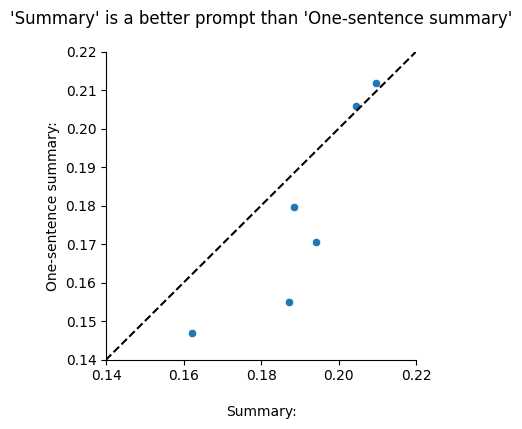

In [8]:
d = (df.pipe(lambda d: d[d.model_scale != "6.9b"])
     [["prompt", "model_scale", "sparse_softmax_k", "rougeL"]]
     .groupby(["prompt", "model_scale", "sparse_softmax_k"]).mean()
     .reset_index()
     .pivot(index=["model_scale", "sparse_softmax_k"], columns="prompt", values="rougeL")
)
plt.figure(figsize=(4, 4))
sns.scatterplot(data=d, y="\nOne-sentence summary:", x="\nSummary:")
plt.plot([0, 1], [0, 1], "k--")
lim = [0.14, 0.22]
plt.xlim(lim); plt.ylim(lim)
plt.title("'Summary' is a better prompt than 'One-sentence summary'", pad=20)
sns.despine();

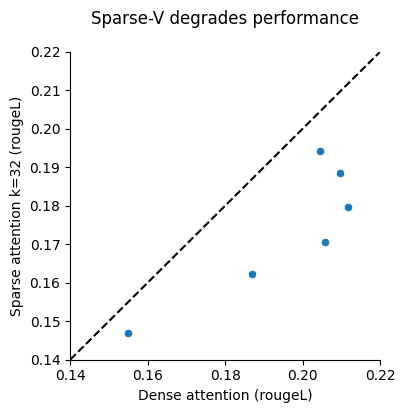

In [3]:
d = (df.pipe(lambda d: d[d.model_scale != "6.9b"])
     [["prompt", "model_scale", "sparse_softmax_k", "rougeL"]]
     .groupby(["prompt", "model_scale", "sparse_softmax_k"]).mean()
     .reset_index()
     .pivot(index=["prompt", "model_scale"], columns="sparse_softmax_k", values="rougeL")
)
plt.figure(figsize=(4, 4))
sns.scatterplot(data=d, y=32, x=2048)
plt.plot([0, 1], [0, 1], "k--")
lim = [0.14, 0.22]
plt.xlim(lim); plt.ylim(lim)
plt.xlabel("Dense attention (rougeL)")
plt.ylabel("Sparse attention k=32 (rougeL)")
plt.title("Sparse-V degrades performance", pad=20)
sns.despine();

In [74]:
print("scale (rouge1, rouge2, rougeL): 'output'")
print()
for _, d in islice(df.pipe(lambda d: d[d.sparse_softmax_k == 2048]).pipe(lambda d: d[d.prompt == "\nSummary:"]).groupby(["id"]), 5):
    print(f"{'Reference':>30}:", repr(d.reference.iloc[0]))
    for _, s in d.iterrows():
        k = f"{s.model_scale} ({s.rouge1:.3f}, {s.rouge2:.3f}, {s.rougeL:.3f})"
        print(f"{k:>30}:", repr(s.output))
    print()

scale (rouge1, rouge2, rougeL): 'output'

                     Reference: 'Rangers beat promotion rivals Hibernian 2-0 last weekend .\nThey closed the gap on Hibs to just three points in the Championship .\nNicky Law believes the club’s promotion destiny is in their own hands .'
    410m (0.191, 0.000, 0.149): ' Rangers have been in a position to win promotion this season, but they have been unable to do so. The team has been in a position to win promotion this season, but they have been unable to do so. The team has been in a position to win promotion this season, but they have been unable to do so'
      1b (0.244, 0.045, 0.222): ' Rangers have been promoted to the SPL for the first time since the end of the 2012-13 season. The club’s first-ever promotion is a major achievement for the new regime, which has been in place since the summer of 2013. The club’s first-ever promotion is a major achievement for the'
    2.8b (0.306, 0.072, 0.188): " Nicky Law has been a key figure in Ranger